### Parallel Hybrid Search Fusion for RAG

#### Introduction: The Best of Both Worlds for High-Fidelity Retrieval
This notebook explores an advanced RAG pattern designed to maximize retrieval accuracy and precision: Parallel Hybrid Search Fusion. This technique addresses the fact that no single search algorithm is perfect. Vector search excels at capturing semantic meaning, while traditional keyword search is unbeatable for finding exact matches. A hybrid system runs both in parallel and fuses their results, creating a more robust and comprehensive retrieval engine.

<p align="center">
  <img src="../../figures/hybrid_search.png" width="800">
</p>

#### The Core Concept: Fusing Lexical and Semantic Search
Vector Search (Semantic): Finds documents that are contextually related to the query, even if they don't share any keywords.
Keyword Search (Lexical): Finds documents that contain the exact terms from the query (e.g., product codes, specific names, acronyms).
By running both searches simultaneously and then combining their unique findings, we create a context that is both semantically relevant and factually precise. This fusion step is critical for preventing failures where one search method misses a crucial document that the other would have found.

#### Role in a Large-Scale System: Fusing Diverse Knowledge Types for High-Fidelity Context
In any real-world knowledge base, information is a mix of prose, tables, and identifiers. A hybrid search system is essential for reliably accessing all of it:

- E-commerce Search: Finding products by a descriptive query ("warm winter coat") and by a specific model number ("XJ-2000").
- Legal & Medical Research: Retrieving documents based on a legal concept (semantic) and those that mention a specific case number or drug name (lexical).
- Technical Support: Finding solutions based on a problem description and those that reference a specific error code.


We will build and compare three RAG systems—Vector-Only, Keyword-Only, and Hybrid—to demonstrate how the hybrid approach retrieves a superior context and generates a more complete and accurate final answer.

In [1]:
from dotenv import load_dotenv
load_dotenv()

True

In [2]:
from langchain_huggingface import HuggingFaceEndpoint, ChatHuggingFace

llm = ChatHuggingFace(
    llm=HuggingFaceEndpoint(
        model="Qwen/Qwen3-4B-Instruct-2507"
    )
)

### Creating the Knowledge Base & Retrievers
We will create a small knowledge base and then build two different retrievers on top of it.

In [3]:
from langchain_core.documents import Document

kb_docs = [
    Document(page_content="The QLeap-V4 processor is our latest flagship AI accelerator. It excels at large-scale parallel computations for deep learning workloads.", metadata={"source": "doc-1"}),
    Document(page_content="Project 'Titan' is a new initiative focused on developing energy-efficient hardware. The primary goal is to reduce the power consumption of our data centers.", metadata={"source": "doc-2"}),
    Document(page_content="A key feature of the QLeap-V4 is its advanced thermal management system. The official error code for overheating is 'ERR_THROTTLE_900'.", metadata={"source": "doc-3"}),
    Document(page_content="Our company is committed to sustainability. Project 'Titan' is a core part of our green computing strategy.", metadata={"source": "doc-4"})
]

#### The Vector Retriever (Semantic)

In [4]:
from langchain_community.vectorstores import FAISS
from langchain_huggingface.embeddings import HuggingFaceEmbeddings

embeddings = HuggingFaceEmbeddings(model_name="Qwen/Qwen3-Embedding-0.6B")
vector_store = FAISS.from_documents(kb_docs, embedding=embeddings)
vector_retriever = vector_store.as_retriever(search_kwargs={"k": 2})

### The Keyword Retriever (Lexical)
We will use TfidfVectorizer from scikit-learn to create a classic keyword search index.

In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
from langchain_core.retrievers import BaseRetriever
from langchain_core.callbacks import CallbackManagerForRetrieverRun
from typing import List

class TfidfRetriever(BaseRetriever):
    vectorizer: TfidfVectorizer
    docs: List[Document]
    k: int = 2

    class Config:
        arbitrary_types_allowed = True

    def _get_relevant_documents(
        self, query: str, *, run_manager: CallbackManagerForRetrieverRun
    ) -> List[Document]:
        query_vec = self.vectorizer.transform([query])
        doc_vectors = self.vectorizer.transform([doc.page_content for doc in self.docs])
        similarities = cosine_similarity(query_vec, doc_vectors).flatten()
        # Get top_k indices
        top_k_indices = np.argsort(similarities)[-self.k:][::-1]
        return [self.docs[i] for i in top_k_indices]

vectorizer = TfidfVectorizer().fit([doc.page_content for doc in kb_docs])
keyword_retriever = TfidfRetriever(vectorizer=vectorizer, docs=kb_docs, k=2)

/var/folders/nm/srw3ygl55jbgpddqwgysqjpm0000gn/T/ipykernel_24795/3401186694.py:8: PydanticDeprecatedSince20: Support for class-based `config` is deprecated, use ConfigDict instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.12/migration/
  class TfidfRetriever(BaseRetriever):


The TfidfRetriever is our lexical search specialist. Unlike the vector retriever, it doesn't understand meaning; it operates purely on word frequencies. It will finding documents that contain the exact, literal keywords from a user's query, even if those keywords are rare or have little semantic weight.

Now, let’s build our Hybrid RAG system. The core of this system is a LangGraph node that runs our two retrievers in parallel and then fuses their results.

In [6]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import RunnablePassthrough
from langchain_core.output_parsers import StrOutputParser

generator_prompt = ChatPromptTemplate.from_messages([
    ("system", "You are an expert technical support agent. Answer the user's question based *only* on the provided context. If the context is insufficient, state that clearly.\n\nContext:\n{context}"),
    ("human", "Question: {question}")
])

def format_docs(docs):
    return "\n\n".join(f"[Source: {doc.metadata.get('source', 'N/A')}] {doc.page_content}" for doc in docs)

# --- RAG Chains ---
rag_chain_vector = (
    {"context": vector_retriever | format_docs, "question": RunnablePassthrough()} 
    | generator_prompt 
    | llm 
    | StrOutputParser()
)
rag_chain_keyword = (
    {"context": keyword_retriever | format_docs, "question": RunnablePassthrough()} 
    | generator_prompt 
    | llm 
    | StrOutputParser()
)

In [7]:
from langgraph.graph import StateGraph, END
from typing import TypedDict, List

class HybridRAGState(TypedDict):
    question: str
    retrieved_docs: List[Document]
    final_answer: str

def parallel_retrieval_node(state: HybridRAGState):
    """Runs vector and keyword search in parallel."""
    print("--- [Hybrid Retriever] Running Vector and Keyword searches in parallel... ---")
    vector_docs = vector_retriever.invoke(state['question'])
    keyword_docs = keyword_retriever.invoke(state['question'])
    
    # Fusion: Combine and deduplicate
    all_docs = vector_docs + keyword_docs
    unique_docs = list({doc.page_content: doc for doc in all_docs}.values())
    print(f"--- [Hybrid Retriever] Fused results: Found {len(unique_docs)} unique documents. ---")
    return {"retrieved_docs": unique_docs}

def generation_node(state: HybridRAGState):
    """Generates the final answer."""
    print("--- [Generator] Synthesizing final answer from fused context... ---")
    context = format_docs(state['retrieved_docs'])
    answer = (
        generator_prompt 
        | llm 
        | StrOutputParser()
    ).invoke({"context": context, "question": state['question']})
    return {"final_answer": answer}

workflow = StateGraph(HybridRAGState)
workflow.add_node("parallel_retrieval", parallel_retrieval_node)
workflow.add_node("generate_answer", generation_node)

workflow.set_entry_point("parallel_retrieval")
workflow.add_edge("parallel_retrieval", "generate_answer")
workflow.add_edge("generate_answer", END)

hybrid_rag_app = workflow.compile()
print("Hybrid RAG graph compiled successfully.")

Hybrid RAG graph compiled successfully.


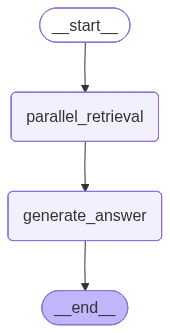

In [8]:
from IPython.display import Image
Image(hybrid_rag_app.get_graph().draw_mermaid_png())

In [19]:
user_query = "What are our company's energy efficiency efforts, and what is the error code for QLeap-V4 overheating?"

#### Running the Vector-Only RAG System

In [20]:
vector_docs = vector_retriever.invoke(user_query)
vector_answer = rag_chain_vector.invoke(user_query)

print("="*60)
print("                VECTOR-ONLY RAG SYSTEM OUTPUT")
print("="*60 + "\n")
print("Retrieved Documents:")
for i, doc in enumerate(vector_docs):
    print(f"{i+1}. {format_docs([doc])}")

print("Final Answer:")
print(vector_answer)

                VECTOR-ONLY RAG SYSTEM OUTPUT

Retrieved Documents:
1. [Source: doc-3] A key feature of the QLeap-V4 is its advanced thermal management system. The official error code for overheating is 'ERR_THROTTLE_900'.
2. [Source: doc-1] The QLeap-V4 processor is our latest flagship AI accelerator. It excels at large-scale parallel computations for deep learning workloads.
Final Answer:
The provided context does not contain information about the company's energy efficiency efforts. However, the error code for QLeap-V4 overheating is 'ERR_THROTTLE_900'.


#### Running the Keyword-Only RAG System

In [21]:
keyword_docs = keyword_retriever.invoke(user_query)
keyword_answer = rag_chain_keyword.invoke(user_query)

print("="*60)
print("                KEYWORD-ONLY RAG SYSTEM OUTPUT")
print("="*60 + "\n")
print("Retrieved Documents:")
for i, doc in enumerate(keyword_docs):
    print(f"{i+1}. {format_docs([doc])}")

print("Final Answer:")
print(keyword_answer)

                KEYWORD-ONLY RAG SYSTEM OUTPUT

Retrieved Documents:
1. [Source: doc-3] A key feature of the QLeap-V4 is its advanced thermal management system. The official error code for overheating is 'ERR_THROTTLE_900'.
2. [Source: doc-1] The QLeap-V4 processor is our latest flagship AI accelerator. It excels at large-scale parallel computations for deep learning workloads.
Final Answer:
Our company's energy efficiency efforts are not detailed in the provided context. However, the error code for QLeap-V4 overheating is 'ERR_THROTTLE_900'.


#### Running the Hybrid Search RAG System

In [16]:
inputs = {"question": user_query}
hybrid_result = None
for output in hybrid_rag_app.stream(inputs, stream_mode="values"):
    hybrid_result = output

print("="*60)
print("                 HYBRID RAG SYSTEM OUTPUT")
print("="*60 + "\n")
print("Retrieved Documents:")
for i, doc in enumerate(hybrid_result['retrieved_docs']):
    print(f"{i+1}. {format_docs([doc])}")

print("Final Answer:")
print(hybrid_result['final_answer'])

--- [Hybrid Retriever] Running Vector and Keyword searches in parallel... ---
--- [Hybrid Retriever] Fused results: Found 2 unique documents. ---
--- [Generator] Synthesizing final answer from fused context... ---
                 HYBRID RAG SYSTEM OUTPUT

Retrieved Documents:
1. [Source: doc-3] A key feature of the QLeap-V4 is its advanced thermal management system. The official error code for overheating is 'ERR_THROTTLE_900'.
2. [Source: doc-1] The QLeap-V4 processor is our latest flagship AI accelerator. It excels at large-scale parallel computations for deep learning workloads.
Final Answer:
Our company's energy efficiency efforts are not detailed in the provided context. However, the error code for QLeap-V4 overheating is 'ERR_THROTTLE_900'.
